## 什麼是遷移學習？

＄ 遷移學習允許我們獲取另一個模型從另一個問題中學到的模式（也稱為權重），並將它們用於我們自己的問題。

＄ 例如，我們可以從ImageNet（數百萬張不同物體的圖像）等數據集中獲取計算機視覺模型的模式，並使用它們來支援我們的FoodVision Mini模型。


＄ 或者，我們可以從語言模型（通過大量文本來學習語言表示的模型）中獲取模式，並將它們用作模型的基礎，對不同的文本樣本進行分類。

## 使用遷移學習有兩個主要好處：

＄ 可以利用現有的模型（通常是神經網路架構），這些模型被證明可以解決與我們自己的問題類似的問題。

＄ 可以利用一個工作模型，該模型已經學習了與我們自己的類似數據的模式。這通常會導致使用較少的自定義數據獲得出色的結果。

## 在何處查找預訓練模型

＄ PyTorch domain libraries：
- 每個 PyTorch 域庫 （ torchvision ， torchtext ） 都帶有某種形式的預訓練模型。那裡的模型直接在 PyTorch 中工作。
- [`torchvision.models`](https://pytorch.org/vision/stable/models.html)
- [`torchtext.models`](https://pytorch.org/text/main/models.html)
- [`torchaudio.models`](https://pytorch.org/audio/stable/models.html)
- [`torchrec.models`](https://pytorch.org/torchrec/torchrec.models.html)

＄ HuggingFace Hub 擁抱臉中心：
- 來自世界各地組織的許多不同領域（視覺、文本、音訊等）的一系列預訓練模型。還有很多不同的數據集。
- https://huggingface.co/models
- https://huggingface.co/datasets

＄ timm （PyTorch 映射模型）庫：
- 幾乎所有最新和最偉大的計算機視覺模型都採用 PyTorch 代碼，以及許多其他有用的電腦視覺功能。
- https://github.com/rwightman/pytorch-image-models

＄ Paperswithcode
- 最新最先進的機器學習論文集，並附有代碼實現。您還可以在此處找到模型在不同任務上的性能基準。
- https://paperswithcode.com/

## 參數配置

In [19]:
class CFG:
  SEED = 42

device = "cuda" if torch.cuda.is_available() else "cpu"

## 導入/下載本節所需的模組

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.2.2+cu121
torchvision version: 0.17.2+cu121


In [2]:
# torchinfo 稍後將幫助我們直觀地表示我們的模型。# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 18.87 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


## 獲取數據

＄ 我們將下載我們一直用於 FoodVision Mini 的相同數據集。

In [3]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


＄ 創建指向訓練和測試目錄的路徑。

In [4]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 建立數據集和 DataLoader

＄ 由於我們已經下載了 going_modular 目錄，因此可以使用在第05節中創建的 data_setup.py 腳本。PyTorch Going Modular 來準備和設置我們的 DataLoader。

＄ 現在的問題是，how to transfor?


### @ 手動建立轉換 torchvision.models （手動建立）（這部分跳過）

＄ 使用預訓練模型時，必須以與進入模型的原始訓練數據相同的方式準備進入模型的自定義數據。




### ＠ 建立轉換 torchvision.models （自動建立）

官分文件：https://pytorch.org/vision/stable/models.html#quantized-models

> 官方文檔：
初始化預訓練模型：從 v0.13 開始，TorchVision 提供了一個新的多權重支援 API，用於將不同的權重載入到現有的模型構建器方法中


＄ 那這邊範例是要使用efficientnet_b0這個模型。

＄ 官方文件：https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0






＄想獲得自動變換，首先導入權重：


In [22]:
# 想獲得自動變換，首先導入權重
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
# weights # EfficientNet_B0_Weights.IMAGENET1K_V1

# 設定權重轉換
auto_transforms = weights.transforms()
auto_transforms

# 將資料，透過自動權重轉換。放進dataloader
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c89a40a6380>,
 ['pizza', 'steak', 'sushi'])

## 獲取預訓練模型

＄ 通常，型號名稱中的數位越大（例如 efficientnet_b0() -> efficientnet_b1() -> efficientnet_b7() ）表示性能越好，但型號越大。

＄ 那這邊選擇torchvision.models.efficientnet_b0()。

In [26]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
# model
# model.features
# model.avgpool # AdaptiveAvgPool2d(output_size=1)
model.classifier
# Sequential(
#   (0): Dropout(p=0.2, inplace=True)
#   (1): Linear(in_features=1280, out_features=1000, bias=True)
# )

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

＄ 目前efficientnet_b0有三個屬性可以看：

- features - 捲積層和其他各種啟動層的集合，用於學習視覺數據的基本表示（這種基本表示/層的集合通常稱為特徵或特徵提取器，“模型的基礎層學習圖像的不同特徵”）。
- avgpool - 獲取 features 層次輸出的平均值，並將其轉換為特徵向量。
- classifier - 將特徵向量轉換為與所需輸出類數具有相同維度的向量（因為在 efficientnet_b0 ImageNet 上進行了預訓練，並且因為 ImageNet 有 1000 個類， out_features=1000 所以是預設值）

## 原模型 & 更改後的模型
＄ 要更改的地方有兩個：
- 分類層：最後握們的輸出只有三個。
- 凍結模型：人家訓練好的模型，我們要直接拿來用，所以裡面抹一層的反向傳播過程中計算要把它改為false。（如果最終有需要再微調即可。）

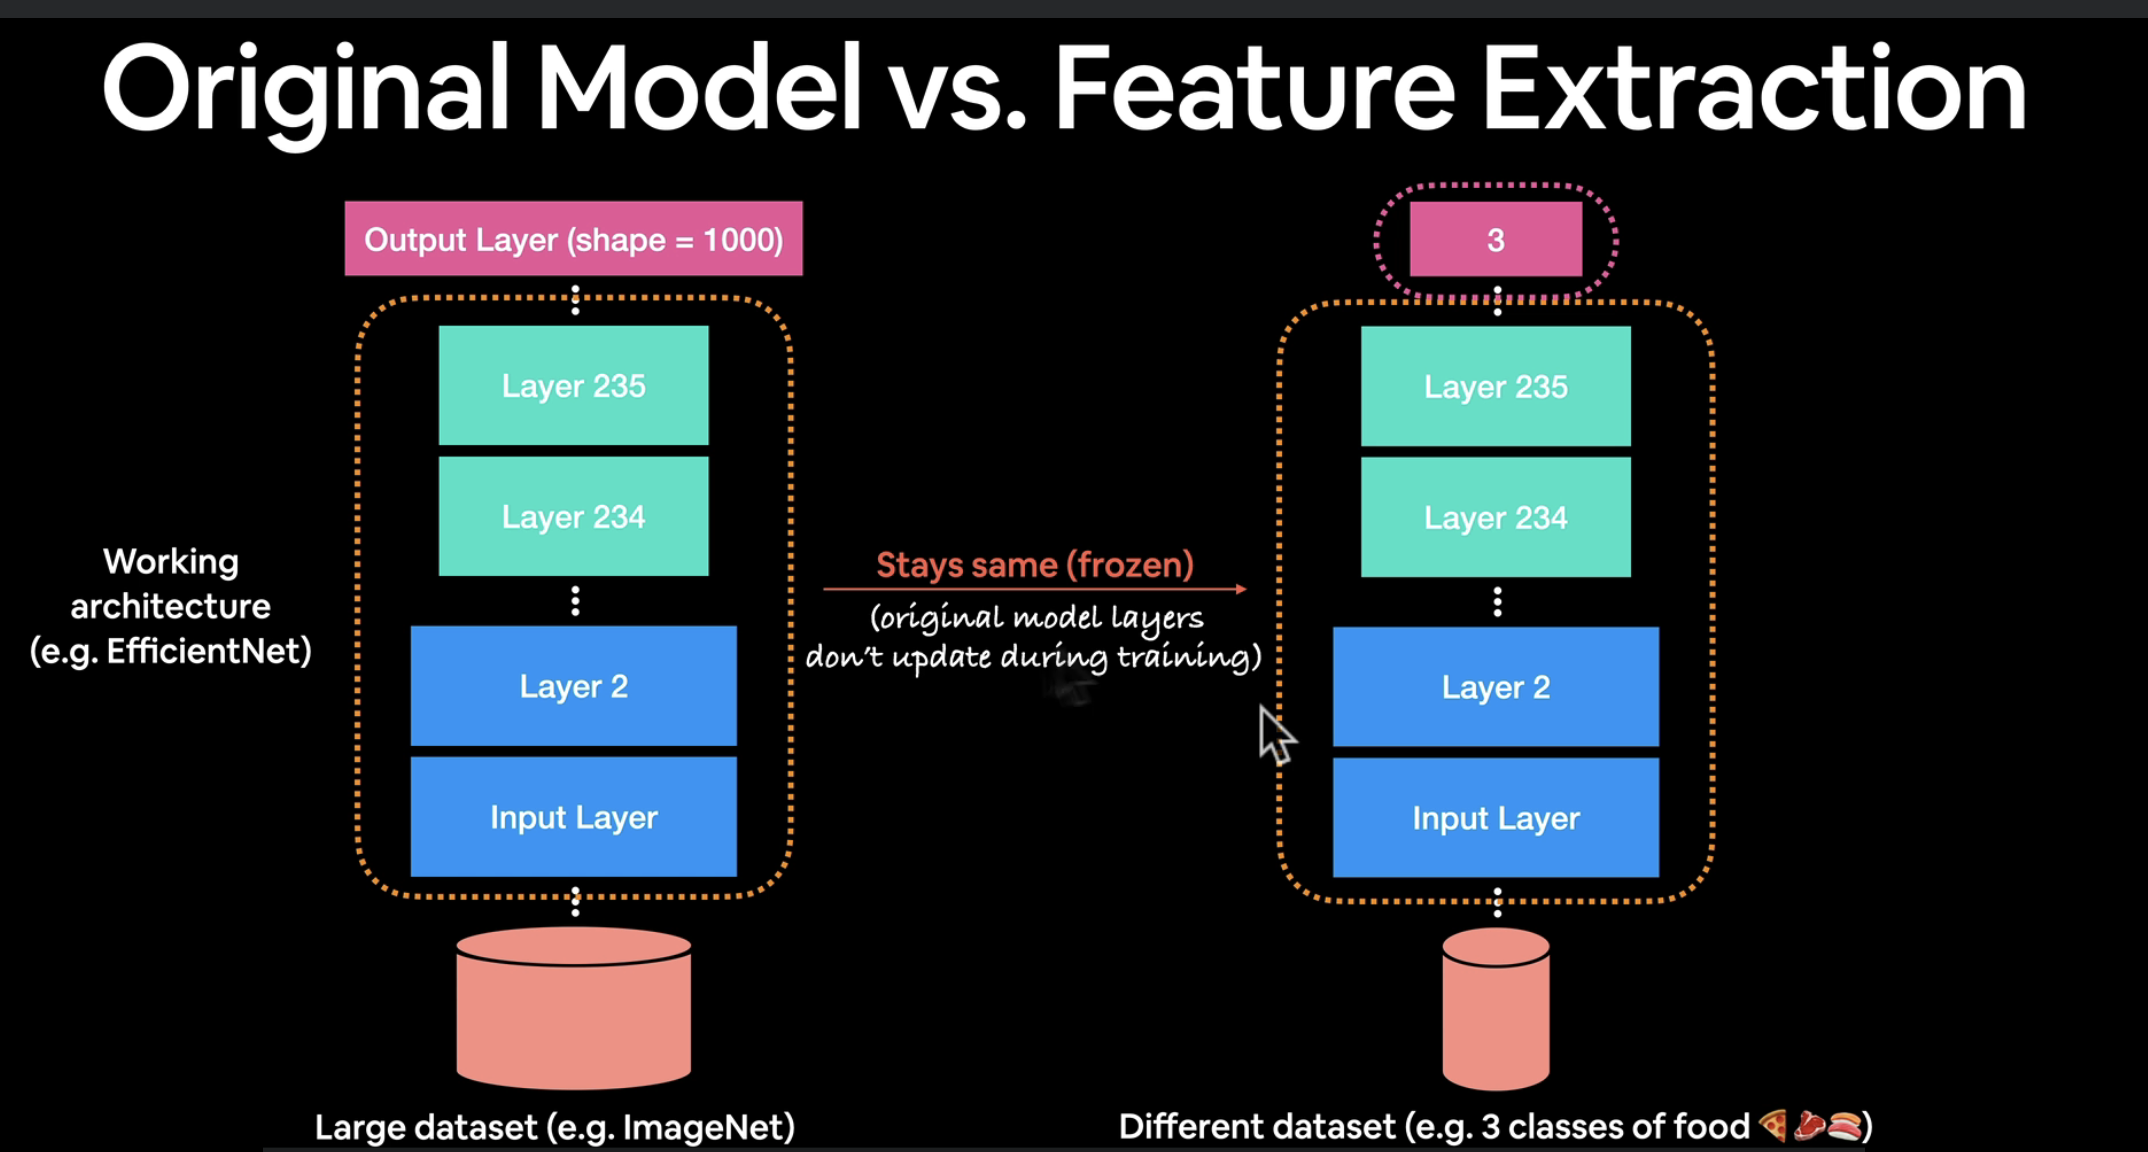



### ＠ 使用 torchinfo.summary()

＄ 要瞭解有關模型的更多資訊，讓我們使用 torchinfo 的方法 summary() 。

＄ 為此，我們將傳入：
- model - 我們想要獲得摘要的模型。
- input_size - 我們希望傳遞給模型的數據的形狀，對於 efficientnet_b0 的情況，輸入大小為 (batch_size, 3, 224, 224) ，儘管其他 efficientnet_bX 變體具有不同的輸入大小。
- col_names - 我們希望看到的有關模型的各種資訊列。
-  col_width - 摘要的列應有多寬。
- row_settings - 要連續顯示哪些功能。

In [29]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### ＠ 凍結基礎模型並更改輸出層以滿足我們的需求

＄ 遷移學習的過程通常是：凍結預訓練模型的一些基礎層（通常是 features 截面），然後調整輸出層（也稱為頭部/分類器層）以滿足您的需求。

In [30]:
# Freeze all base layers in the "features"
for param in model.features.parameters():
    param.requires_grad = False

In [31]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [32]:
# 將模型的分類層進行修改
torch.manual_seed(CFG.SEED)
torch.cuda.manual_seed(CFG.SEED)
output_shape = len(class_names)

# 替換掉原本的分類層
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

In [33]:
"""
verbose 參數是用來控制 summary 函數的詳細程度。當 verbose 設置為不同的值時，會影響函數的輸出。

通常，verbose 參數有以下幾種設置：
verbose=0: 精簡模式，只輸出摘要信息，不包括每一層的詳細信息。
verbose=1: 默認模式，輸出每一層的詳細信息，包括輸入大小、輸出大小、參數數量等。
verbose=2: 詳細模式，與默認模式相似，但會在輸出中包括更多的詳細信息，例如每一層的計算量等。

"""
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 訓練模型

In [35]:
# 創建一個損失函數和一個優化器。
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
# Set the random seeds
torch.manual_seed(CFG.SEED)
torch.cuda.manual_seed(CFG.SEED)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
[INFO] Total training time: 190.031 seconds


## 通過繪製損耗曲線來評估模型

[INFO] Couldn't find helper_functions.py, downloading...


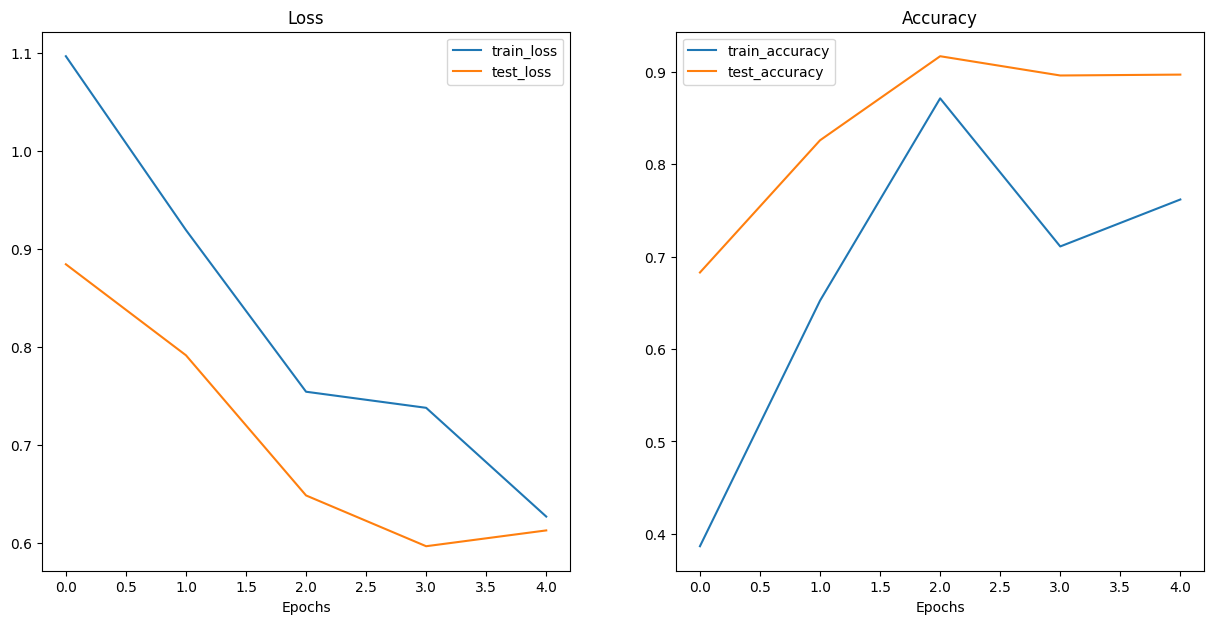

In [37]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 對測試集中的圖像進行預測

＄ 我們必須記住的一件事是，為了讓我們的模型對圖像進行預測，圖像必須與我們的模型訓練的圖像格式相同。這意味著我們需要確保我們的圖像具有：
- 相同的數據類型 - 如果我們的圖像是不同的數據類型（例如， torch.int8 vs. torch.float32 ），我們將收到數據類型錯誤。
- 同一設備 - 如果我們的圖像與我們的模型位於不同的設備上，我們將收到設備錯誤。

In [40]:
from typing import List, Tuple

from PIL import Image

# 1. 接收一個已訓練的模型、類別名稱、圖片路徑、圖片大小、轉換器以及目標設備
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. 打開圖片
    img = Image.open(image_path)

    # 3. 創建圖片的轉換（如果不存在）
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### 對圖片進行預測 ###

    # 4. 確保模型在目標設備上
    model.to(device)

    # 5. 打開模型的評估模式和推論模式
    model.eval()
    with torch.inference_mode():
      # 6. 對圖片進行轉換並增加一個額外的維度（模型要求樣本在 [batch_size, color_channels, height, width] 中）
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. 對帶有額外維度的圖片進行預測並發送到目標設備
      target_image_pred = model(transformed_image.to(device))

    # 8. 將 logits 轉換為預測概率（使用 torch.softmax() 進行多類別分類）
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. 將預測概率轉換為預測標籤
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. 繪製帶有預測標籤和概率的圖片
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);


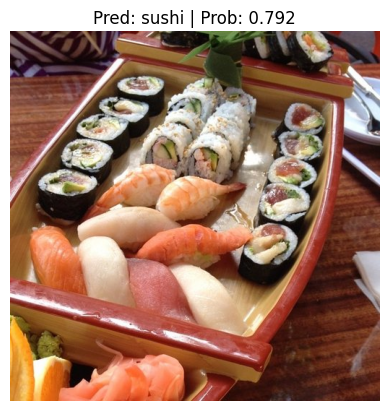

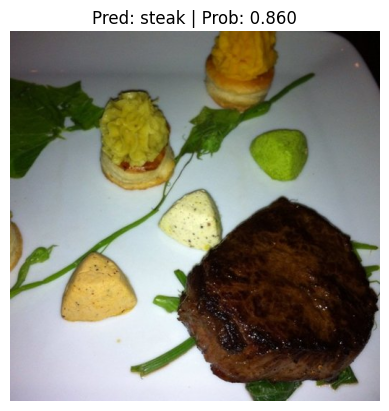

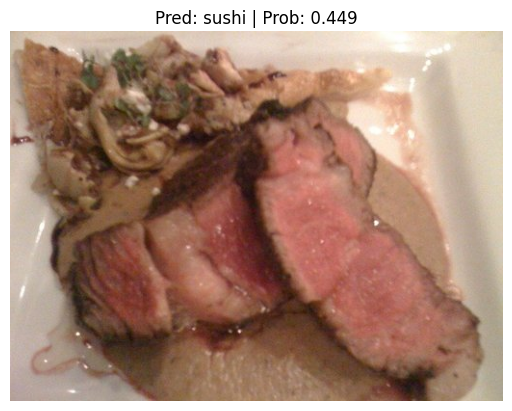

In [43]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

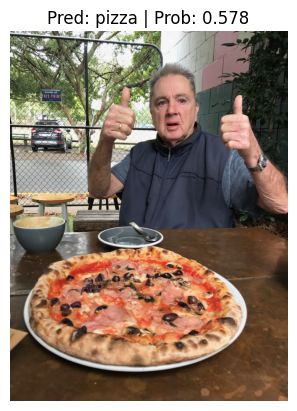

In [44]:
# 對新照片進行判斷
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)